In [1]:
import pandas as pd
from random import randint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers

max_length = 2410
tokens = ['<PAD>', '<START>', '<END>', 'a', 't', 'c','g'] 

data = pd.read_csv('/kaggle/input/capstone-sequences/yamagata_seq_to_seq.csv')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
encoder_inputs_data = []
decoder_inputs_data = []
target_outputs_data = []
for i in range(len(data)):
    base = data.loc[i]['base']
    mutated = data.loc[i]['mutated']
    encoder_inputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in base])
    decoder_inputs_data.append([tokens.index('<START>')] + [tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated])
    target_outputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated] + [tokens.index('<END>')])

encoder_inputs_data = pad_sequences(encoder_inputs_data, padding='post',maxlen=max_length)
decoder_inputs_data = pad_sequences(decoder_inputs_data, padding='post',maxlen=max_length)
target_outputs_data = pad_sequences(target_outputs_data, padding='post',maxlen=max_length)

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, query,value, training,causal_mask):
        attn_output = self.att(query=query, value=value,use_causal_mask=causal_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(value + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [4]:
num_heads = 4
embed_dim = num_heads*64
ff_dim = embed_dim*4
encoder_vocab_size = 8
decoder_vocab_size = 8
sequence_length = 2420

In [5]:
encoder_inputs = layers.Input(shape=(2410,))
encoder_masked_input = layers.Masking(mask_value=0)(encoder_inputs)
encoder_embeddings = TokenAndPositionEmbedding(sequence_length, encoder_vocab_size, embed_dim)(encoder_masked_input)


encoder_attention = layers.MultiHeadAttention(name='encoder_attention',num_heads=num_heads,key_dim=embed_dim)
encoder_context, encoder_attention_score = encoder_attention(query=encoder_embeddings,value=encoder_embeddings,return_attention_scores=True,use_causal_mask=False)
encoder_drop = layers.Dropout(0.2)(encoder_context)
encoder_residual = encoder_embeddings + encoder_drop
encoder_layernorm = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)
ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])(encoder_layernorm)
ff_drop = layers.Dropout(0.2)(ff)
encoder_residual = encoder_layernorm + ff_drop
encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)


encoder_attention_2 = layers.MultiHeadAttention(name='encoder_attention_2',num_heads=num_heads,key_dim=embed_dim)
encoder_context, encoder_attention_score = encoder_attention_2(query=encoder_output,value=encoder_output,return_attention_scores=True,use_causal_mask=False)
encoder_drop = layers.Dropout(0.2)(encoder_context)
encoder_residual = encoder_embeddings + encoder_drop
encoder_layernorm = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)
ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])(encoder_layernorm)
ff_drop = layers.Dropout(0.2)(ff)
encoder_residual = encoder_layernorm + ff_drop
encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)


encoder_attention_3 = layers.MultiHeadAttention(name='encoder_attention_3',num_heads=num_heads,key_dim=embed_dim)
encoder_context, encoder_attention_score = encoder_attention_3(query=encoder_output,value=encoder_output,return_attention_scores=True,use_causal_mask=False)
encoder_drop = layers.Dropout(0.2)(encoder_context)
encoder_residual = encoder_embeddings + encoder_drop
encoder_layernorm = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)
ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])(encoder_layernorm)
ff_drop = layers.Dropout(0.2)(ff)
encoder_residual = encoder_layernorm + ff_drop
encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)

encoder_attention_4 = layers.MultiHeadAttention(name='encoder_attention_4',num_heads=num_heads,key_dim=embed_dim)
encoder_context, encoder_attention_score = encoder_attention_4(query=encoder_output,value=encoder_output,return_attention_scores=True,use_causal_mask=False)
encoder_drop = layers.Dropout(0.2)(encoder_context)
encoder_residual = encoder_embeddings + encoder_drop
encoder_layernorm = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)
ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])(encoder_layernorm)
ff_drop = layers.Dropout(0.2)(ff)
encoder_residual = encoder_layernorm + ff_drop
encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)


encoder_attention_5 = layers.MultiHeadAttention(name='encoder_attention_5',num_heads=num_heads,key_dim=embed_dim)
encoder_context, encoder_attention_score = encoder_attention_5(query=encoder_output,value=encoder_output,return_attention_scores=True,use_causal_mask=False)
encoder_drop = layers.Dropout(0.2)(encoder_context)
encoder_residual = encoder_embeddings + encoder_drop
encoder_layernorm = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)
ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])(encoder_layernorm)
ff_drop = layers.Dropout(0.2)(ff)
encoder_residual = encoder_layernorm + ff_drop
encoder_output = layers.LayerNormalization(epsilon=1e-6)(encoder_residual)

decoder_inputs = layers.Input(shape=(2410,))
decoder_masked_input = layers.Masking(mask_value=0)(decoder_inputs)
decoder_embeddings = TokenAndPositionEmbedding(sequence_length, decoder_vocab_size, embed_dim)(decoder_masked_input)

decoder_block = TransformerBlock(embed_dim, num_heads, ff_dim)
decoder = decoder_block(query=decoder_embeddings,value=encoder_output,causal_mask=True)


distributions = layers.Dense(decoder_vocab_size, activation="softmax")(decoder)


model = keras.Model(inputs=[encoder_inputs,decoder_inputs],outputs = distributions)

In [6]:
opt = keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],optimizer=opt)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2410)]       0           []                               
                                                                                                  
 masking (Masking)              (None, 2410)         0           ['input_1[0][0]']                
                                                                                                  
 token_and_position_embedding (  (None, 2410, 256)   621568      ['masking[0][0]']                
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 encoder_attention (MultiHeadAt  ((None, 2410, 256),  1051904    ['token_and_position_embeddin

In [8]:
model.fit(x=[encoder_inputs_data,decoder_inputs_data],y=target_outputs_data,epochs=1,batch_size=4,verbose=1)

11209/11209 [==============================] - 4968s 441ms/step - loss: 0.1610 - accuracy: 0.9602


In [ ]:
model.save_weights('large.h5')

In [9]:
import numpy as np
from Bio import pairwise2

/opt/conda/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# ENCODER LAYER 1

1/1 [==============================] - 0s 85ms/step


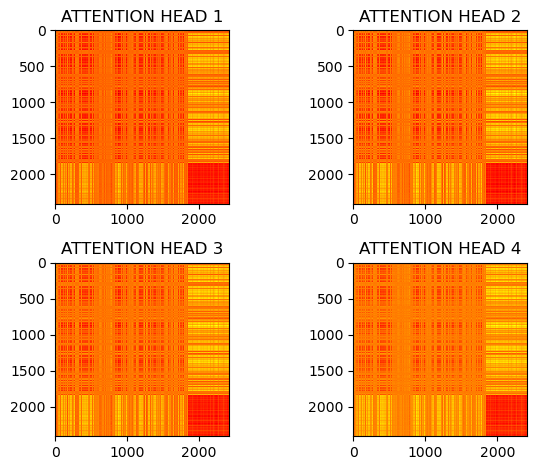

In [61]:
import matplotlib.pyplot as plt
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_attention').output)
sample = 10
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')
axes[0, 0].set_title('ATTENTION HEAD 1')
axes[0, 1].imshow(encoder_pred[1][0][1], cmap='hot', interpolation='nearest')
axes[0, 1].set_title('ATTENTION HEAD 2')
axes[1, 0].imshow(encoder_pred[1][0][2], cmap='hot', interpolation='nearest')
axes[1, 0].set_title('ATTENTION HEAD 3')
axes[1, 1].imshow(encoder_pred[1][0][3], cmap='hot', interpolation='nearest')
axes[1, 1].set_title('ATTENTION HEAD 4')
plt.tight_layout()

plt.show()

# ENCODER LAYER 2

1/1 [==============================] - 0s 301ms/step


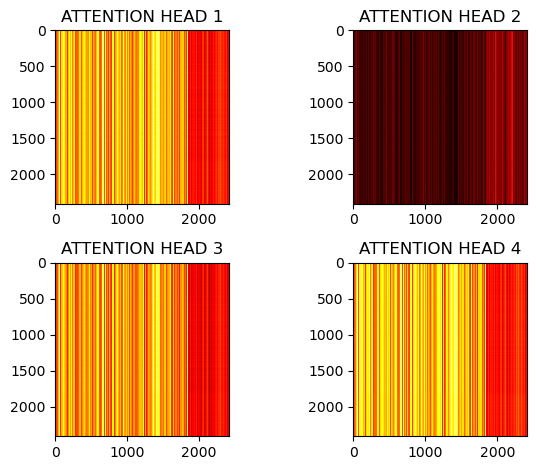

In [55]:
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_attention_2').output)
sample = 10
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')
axes[0, 0].set_title('ATTENTION HEAD 1')
axes[0, 1].imshow(encoder_pred[1][0][1], cmap='hot', interpolation='nearest')
axes[0, 1].set_title('ATTENTION HEAD 2')
axes[1, 0].imshow(encoder_pred[1][0][2], cmap='hot', interpolation='nearest')
axes[1, 0].set_title('ATTENTION HEAD 3')
axes[1, 1].imshow(encoder_pred[1][0][3], cmap='hot', interpolation='nearest')
axes[1, 1].set_title('ATTENTION HEAD 4')
plt.tight_layout()
plt.show()

# ENCODER LAYER 3

1/1 [==============================] - 0s 392ms/step


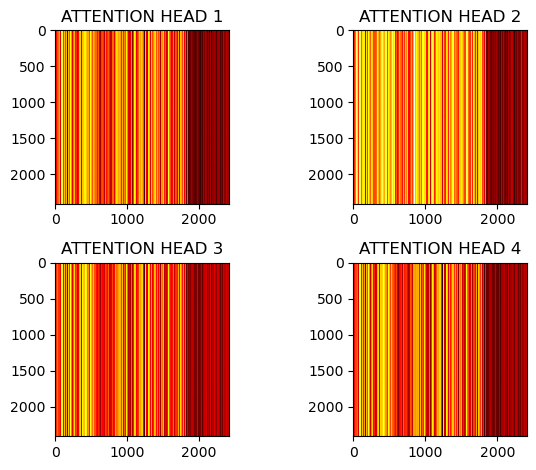

In [54]:
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_attention_3').output)
sample = 10
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')
axes[0, 0].set_title('ATTENTION HEAD 1')
axes[0, 1].imshow(encoder_pred[1][0][1], cmap='hot', interpolation='nearest')
axes[0, 1].set_title('ATTENTION HEAD 2')
axes[1, 0].imshow(encoder_pred[1][0][2], cmap='hot', interpolation='nearest')
axes[1, 0].set_title('ATTENTION HEAD 3')
axes[1, 1].imshow(encoder_pred[1][0][3], cmap='hot', interpolation='nearest')
axes[1, 1].set_title('ATTENTION HEAD 4')
plt.tight_layout()
plt.show()

# ENCODER LAYER 4

1/1 [==============================] - 0s 447ms/step


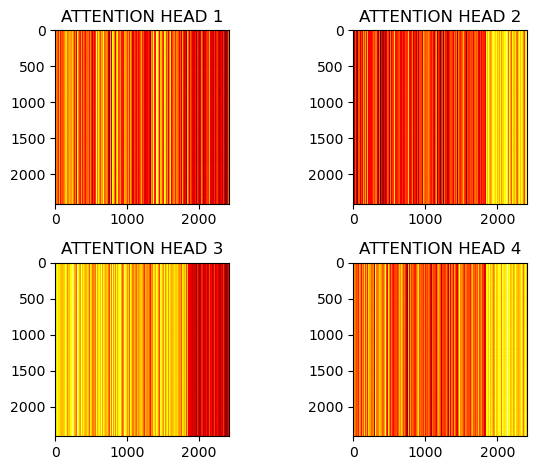

In [53]:
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_attention_4').output)
sample = 10
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')
axes[0, 0].set_title('ATTENTION HEAD 1')
axes[0, 1].imshow(encoder_pred[1][0][1], cmap='hot', interpolation='nearest')
axes[0, 1].set_title('ATTENTION HEAD 2')
axes[1, 0].imshow(encoder_pred[1][0][2], cmap='hot', interpolation='nearest')
axes[1, 0].set_title('ATTENTION HEAD 3')
axes[1, 1].imshow(encoder_pred[1][0][3], cmap='hot', interpolation='nearest')
axes[1, 1].set_title('ATTENTION HEAD 4')
plt.tight_layout()
plt.show()

# ENCODER LAYER 5

1/1 [==============================] - 1s 566ms/step


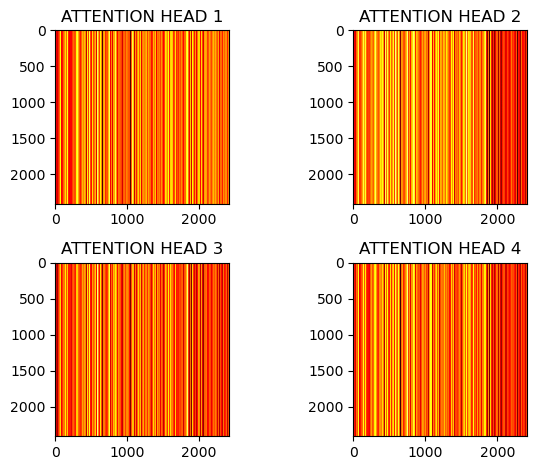

In [52]:
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_attention_5').output)
sample = 10
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')
axes[0, 0].set_title('ATTENTION HEAD 1')
axes[0, 1].imshow(encoder_pred[1][0][1], cmap='hot', interpolation='nearest')
axes[0, 1].set_title('ATTENTION HEAD 2')
axes[1, 0].imshow(encoder_pred[1][0][2], cmap='hot', interpolation='nearest')
axes[1, 0].set_title('ATTENTION HEAD 3')
axes[1, 1].imshow(encoder_pred[1][0][3], cmap='hot', interpolation='nearest')
axes[1, 1].set_title('ATTENTION HEAD 4')
plt.tight_layout()
plt.show()

In [15]:
data = pd.read_csv('/kaggle/input/capstone-sequences/victoria_seq_to_seq (1).csv')
encoder_inputs_data = []
decoder_inputs_data = []
target_outputs_data = []
for i in range(len(data)):
    base = data.loc[i]['base']
    mutated = data.loc[i]['mutated']
    encoder_inputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in base])
    decoder_inputs_data.append([tokens.index('<START>')] + [tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated])
    target_outputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated] + [tokens.index('<END>')])

encoder_inputs_data = pad_sequences(encoder_inputs_data, padding='post',maxlen=max_length)
decoder_inputs_data = pad_sequences(decoder_inputs_data, padding='post',maxlen=max_length)
target_outputs_data = pad_sequences(target_outputs_data, padding='post',maxlen=max_length)

In [16]:
model.evaluate([encoder_inputs_data,decoder_inputs_data],target_outputs_data,batch_size=4)

12237/12237 [==============================] - 2025s 165ms/step - loss: 0.2173 - accuracy: 0.9465


[0.2173406481742859, 0.9464579820632935]

In [17]:
sample = 320
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 1s 837ms/step
2352 2354
GATT-ACATTGGCCAAAATTGAATTGTTGAAA-CAACTGCTAAGTG-ACAATGAAGCCTAAA-CAGTTTTGAA-GTT-AA-CAACAG-TAGACCAATATAAT-ATTT--TAAGAAAATTCAATACATCAAAA--ATTGAAAAGAATCCTTCACTAAGGATGAAA-TGGT-CCATGTA-TTCG-AATATT-CCCTTGC-CTCTAACCAATCACAA---C-ATA-G-CAACTA-A-AATCCCCT-GGAATC-CAAATT--AATACAACTTAACA-CAAATGCTC-AAGACATC-GGCA-CCAACGA--CCAAATA-T--TCGAAATCC--CAGC-GTTTACTTAC--TCCAG---TACATATCT--ACCAATAGC-AGATACTC-AAGC-TTTCGAAAAAC---TCTC-CGAAAAC-CTTTTT-CTCAGAACAA-TGAT-ACTTGACAAT-GCCACTTGGACC--CC-AATAACTTTCGT--CCCAGTC-GAAAA-AGTGAC-AAAAAGGC-TACTGCTAAC-CCCTCTCACCAAGGAAATGCCTCAAA---ATGAGGCAA-A-CAATGTA-ATAATTA--AAATACTAT-T-CCCTAAAGAAGCAGGAATACCAAAC-A-AATCCACTTGGATACATAGGGAACTGATAAAAGAAAACC--GAGAAAAATTC-ACAGA--AACGA-TGATAAG-TCCAAA-CGTACTGA-CATACATGCTTGAAAA-AGAACTGGTTC-CTCA-AAGAAC-ATTCTTGCCAGTCA--CAGT-AT-CAACATC--CTCCC-AGTTCATAGACA-TGCTACACTGCTTCA-AAGATG-GAAAC-TTCA--A-ACAAATAGGG---CACCCAGGAGGGAATAAATG-AACTGAA-TCTAGA-TCTCAATCAATC-ATAGTAGCTTA-TAGAAAAATAATCAGGA-GATCAA

In [19]:
sample = 0
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 71ms/step
1752 1758
ATGAAGGT-AATAATTGTACTACTCATGGTAGTAACATCCAAC-GCAGATCGAATCTGCACTGGGATAACATCT-TCAAACTCACCTC-ATGTGGTCAAAACA-GCTACTCAAGGGGAAG-TCAATGTGACTGGTGTGATACCACTGACAACAACACCAACA--AAATCTCATTTTGCAAATCTCAAAGGAACAAAGA-CCAGAGGGAAACTATGCCCAAAC-TGTC-TCAACTGT-ACAGATCTGGAT-GTGGCCTTGGGCAGACCAATGTGTA-T--A-GGG-AC-CATACCT-TCAG-CAA-AAGCTT-CAATACTCCAC-GAAGTCAGACCTGTTACATCC-GGGTGCTTTCCTATAATGCACGACAGAACAAAAATC-AGACAGCTA-CCCAATC-TTCTCAGAGGATAT-GAACATATCAGA-TTATCAACC-CATAACGTTATCAAC-GCAGAAAG-GGCACCAGGAGGACCCTACAGAC--TTGGAACCTCAGGA-TCTTGCCCTAACGTTACCAGTA-G-AAG-CGGATTCTT-CGCAACAATGGCTTGGGCT-GTCCCAAAG----GACAACAA-AA--CAGCAACGAACCCA--C-T-AACAG-TAGAAGTACCATACATTTGTACAA-AAGGAGAAGACCAAATTACT-GTTTGGGGGTTCCAT-TCTGATAACA-AAACCCAAATGA--AAAACCTCTATGGAG-ACTCAAAT-CCTCA-A-AAGTTCACCTCATCTGCCAAT-GGAGTA-ACCACACATTAT-GTTTCT-CAGATTGGTGGCTTCCCAAATCAAACAGAAGACGGAGGG-CTACCACAAAGC-GGC-AGAATTGTTGTTGATTACATGGTA-CAAAAAC-CTGGGAAAACAGGAACAGT-TGT-C-TATCAAAGAGGTG-TTTTG-TTGCCTCAAAAG-GTGTG

In [20]:
sample = 903
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 72ms/step
1757 1758
ATGAAGGT-AATAATTGTACTACTCATGGTAGC-AACATCCAATGCAGATCGAATCTGCACTGGGATAACATCGA-CAAACTA-ACCACATGTCGTCAAAACTGCTAA-TCAAGGGGAGGTCAATAAG--ACCGA-TGTAATACCACTGACAACAACACCCACCAAATCTCATTTTGCAAATCTA-AAAGA-AACAGAAACCAAAGGG--AAACTATA-CAC-AAAATGCCTCAACA-GCACATA-A-CTGGATGTAGCCTTGGGCAGACCAAAATGCACAGGGAAAATACCCA-CGG-G-AAGAG-TTTCAATACTCCATC-AAGGG--AGACCTGTTACAA-CTGGGTGCTTTCCA-ATAATGCACGATAGAACAAAAATTAC-ACAGCTGCG-TAATC-TTCTCCGAGGAA-ACGAACATA-TCAGGTTATCAACG-CACAACA-TTATCAATGCAGAAGATGCACCAGGAGGACCCTACAAAATTAG-AACCTCAGGGTCTTGCCA-TAACG-TTACCAATGGAAACGGATTCTTCGCAACAATAG-CTTGGGCCGTCCCAAAAAACGACAAAAACAAAACAGCAACAAATCA-ATTAAG-AATAGAAGG-ACCATACATTTGTACAGAAGGAGAAGAGC-AAATTACCGTTTGGGGGTG-CCACTCTGACAACGAGACCCAAATGGCAAAGCTCTATGAGA--ACTCAAAGCCCCAGAAGTTCACCTCATCTGCCAACGGAA-TGACCACACATTACGTTTCACAA-ATTGGTGGCTAGG-C--AAATCAAACAGAAGACGGAGGACTACCACAAAA-TGGA-AGAATTGTTGTAGATGA--A-ATGGTT-CAAAAATGG--GGAAAAACAGGAACAATTACCTAA-CAAAGAGGTATTTTATTA-CCTCAAAAGGTGTGAAG--CGCAAGTG

In [21]:
sample = 20
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 87ms/step
1683 1683
ATGC-CCAACATGGATATTGACGGTATCAACACTGGGACAATTGACAAAGCACCGGAAGAAATAACTTCTGGAACCAGTGGGACAACCAGACCAATCATCAGACCAGCAACCCTTGCCCCACCAAGCAACAAACGAACCCGGAACCCATCCCCGGAAAGAGCAACCACAAGCAGTGAAGCTGATGTCGGAAGGAAAACCCAAAAGAAACAGACCCCGACAGAGATAAAGAAGAGCGTCTACAATATGGTAGTGAAACTGGGTGAATTCTATAACCAGATGATGGTCAAAGCTGGACTCAACGATGACATGGAGAGAAACCTAATCCAAAATGCG-CATGCTGTGGAAAGAATTCTATTGGCTGCCACTGATGACAAGAAAACTGAATTCCAGAAGAAAAAGAATGCCAGAGATGTCAAAGAAGGGAAAGAAGAAATAGATCACAACAAAACAGGAGGCACCTTTTACAAGATGGTAAGAGATGATAAAACCATCTACTTCAGCCCTATAAGAGTTACCTTTTTAAAAGAAGAGGTAAAAACAATGTACAAAACCACCATGGGGAGTGATGGCTTCAGTGGACTAAATCACATAATGATTGGGCATTCACAGATGAATGATGTCTGTTTCCAAAGATCAAAGGCACTAAAAAGAGTTGGACTTGACCCTTCATTAATCAGTACCTTTGCAGGAAGCACACTCCCCAGAAGATCAGGTGCAACTGGTGTTGCGATCAAAGGAGGTGGAACTTTAGTGGCTGAAGCCATTCGATTTATAGGAAGAGCAATGGCAGACAGAGGGCTATTGAGAGACATCAAAGCCAAGACTGCATATGAAAAGATTCTTCTGAATCTAAAAAACAAATGCTCTGCGCCTC-AACAAAAGGCTCTAGTTGATCAAGTGATCGGAAGTAGAAATCCAGGGATTGCAGACATTGA

In [23]:
sample = 100
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 70ms/step
1807 1810
TTCC--C--GTGAACTTCAAGTGGCAACAA-AGGAAGAGAAAAA---AAAA--AAAA---CCAAAAAAAAAA-A-GGA----G--GGAA-A-CAACACAA-GAA--A-AATAAAA--A-AAA-CAC-GGAAAA-AAATAACTTCTAG-AACCAAAAAA-----ACAACAA-A-ACCAAA-CATCAA-ACCAGCAACCCTTGAACCA--AC-AAGA-AACAAACGAACAAAA----AACCCAA-CCACA-GA-AAA-AT-CAACAACAAAAAA-AA--A---AA-CA-GATTT-TAA---AACG-AAAACCA-AAAAGAAACAAAAA-ACCACA--A-A-A-ATAAAA-AAAAGCT-TCG-AG-AATATCGTGTTAA---AACAC-GC--TGAATTCTATAACCAAAAGA-GAATCACCC---CAAAAC-CTAAA--A---AA--A--ACATAGA-A-A-AACACCTAATTGG-AAA-TGCA-CAG-GCAAAA-GAA---AAA-AATCTAACA-A----CTA-CCACTCAC-A--ACAGA-AAAACAAA--AATAC-CCAAAA-AA-AAAAA-AA--CCACCC-A-A-GTCAAAGAAAGAAAA--AAAGAAAA-AAATA-A-CA-AA-AAAACAGCACG---CACCTTAT-ACAAGATAA--TAAAAGAA-A--ATAAAACCATCTAAA-T-CAA-CCA-TATAAA-AT-TCACAAA-TTG---AAAAGAAA-ACC--TAAAAACAATC-TAA-AAAAGC-AGC-ATAAGGAGCAAAGA---AT---T-CAC-CAG-ACA-AAATCACATAATGATTAGG-CATAAACAAATAA-ACA-AT-AA--ATC--CAA-----CCAAAA-ATCAAACT--CACTAAAAACA-AGC--GCA-A-TAA--ACCCTTAAAA-A--AA-CAGTACCTTTA-CAGC-A

In [24]:
sample = 1838
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 70ms/step
1683 1683
ATGC-CCAACATGGATATCGACGGTATGAACACTGGGACAATTGACAAAACACCGGAAGAAATAACTTCTGGAACCAGTGGGACAACCAGACCAATCATTAGACCAGCAACCCTTGCCCCACCAAGCAACAAACGAACCCGTAACCCATCCCCGGAAAGAGCAACCACAAGCAGTGAAGATGATGTCGGAAGGAAAGCCCAAAAGAAGCAGACCCCGACAGAGATAAAGAAGAGCGTCTACAACATGGTGGTGAA-ACTGGGCGAATTCTACAACCAGATGATGGTG-AAAGCTGGACTCAATGATGACATGGAGAGAAATCTAATCCAAAATGCGCATGCCGTGGAAAGAATTTTATTGGCTGCCACTGATGACAAGAAAACCGAGTTCCAGAAGAAAAAGAATGCCAGAGATGTCAAAGAAGGGAAGGAAGAAATAGATCACAACAAAACAGGAGGCACCTTTTACAAGATGGTAAGAGATGATAAAACCATCTATTTCAGCCCTATAAGAATTACCTTTTTAAAAGAAGAGGTGAAAACAATGTACAAAACCACCATGGGGAGTGATGGCTTCAGTGGATTAAATCACATAATGATTGGGCATTCACAGATGAATGATGTCTGTTTCCAAAGATCAAAGGCACTAAAAAGAGTTGGACTTGATCCTTCATTAATCAGTACCTTTGCGGGAAGCACAGTCCCCAGAAGATCAGGTGCGACTGGTGTTGCAATCAAAGGAGGTGGAACCTTAGTGGCTGAAGCCATTCGATTTATAGGAAGAGCAATGGCAGACAGAGGGCTATTGAGAGACATCAAAGCCAAGACTGCCTATGAAAAGATTCTTCTGAATCTAAAGAACAAATGCTCTGCGCCCCAACAAAAGGCTCTAGTTGATCAAGTA-ATCGGAAGCAGAAATCCGGGGATA-GCAGACATT

In [58]:
sample = 35
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([encoder_inputs_data[sample:sample+1],decoded_seq])
a = [tokens[np.argmax(i)] for i in pred[0] if np.argmax(i)!=0]
a = ''.join(a)
b = [tokens[i] for i in decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)
print(len(a),len(b))

from Bio import pairwise2
alignments = pairwise2.align.globalxx(a.upper(), b.upper())
best_alignment = alignments[0]

# Print the best alignment
print(pairwise2.format_alignment(*best_alignment))
print('\n',best_alignment.score/len(b))

1/1 [==============================] - 0s 90ms/step
1513 1516
---CTGAGGCTAA-TAGGCCAAAAAAAA--AA-AATGCG-ACCTA-CAACAATAA-A-AAA-GTTAACCCTAGTTGG-C--AG-ATCACGAGGAGA-AG-A--ATTATCACTATATGTGTCAGA-TTCATTGTCATACTTACA-ATATTA-GGATATATTA-CTAAAATTCTA-ACCAACAGGAA-TAACTGAA-AC-AACAATGCCCTAAAAAT---A--AT-CAAACGAA-A-CAAATGATA--AGAAAG-TA---AACCA-TAATC--CAAA-AAAAGGGA-TA-ACAA-TTCTTCTCCCAA-AACCGCA-A-TGGACAA-ACCG-GCGTTG-AGGT-T-GCCCGGGCTCAACCTTC-CAGAAAA-CACTCCA-AATTAGCCCTCATAGATTCCG-AGAAACCAAAGGAAACA-CAA-CTCCCTTGATAATAAGGAA-AAC-TAAAAA---A--GCTTGTGGACCAAAG-GAATGCAAACACAA---GACA-CTAAAAC--ATA-ATGCAA-CCCAAACAA-AGGG--AC-ACA-ACAATGGAACAAGAGAAAAAA-A-A-A-AAA-AA-CTAAGA--CATCTAATTTCAGTCAAATTGGGCAAAATCCCAACAGTAA-AAAACTCCATTTGA-CA-A-ATGGCAA-CATGGAGCGGGGG-C-GCATAA-C-ATGATGGGAA-ACA--AA-GA-ACATAGA-A-CGGAGTTGAA-GGCCA-TGACAAA-AATGCATTAA--TCAAAAA-AAAATATGGAA-AAGCATATACA-GAAA-A-ATACCATTCCTATA-CAAACAACATCCTAAGAACACAAA-AAAGTGCA-TGCAAAT-GCAA-CAGACA----AAATG-GTTAGGT-TATA--ATAACTGATGA-CTCAGCTTCAAG-TA-TTAA-TGAAA-GCAGATTTCTA-AAGATACAACAT

In [22]:
model.save_weights('influenza_11M.h5')